## Measuring the Impact of a Website Redesign the Bayesian Way

### Background

You work for an early-stage startup in Germany. Your team has been working on a redesign of the landing page. The team believes a new design will increase the number of people who click through and join your site. 

They have been testing the changes for a few weeks, and now they want to measure the impact of the change and need you to determine if the increase can be due to random chance or if it is statistically significant.


### The Data

#### Redesign test Data

* "treatment" - "yes" if the user saw the new version of the landing page, no otherwise.
* "new_images" - "yes" if the page used a new set of images, no otherwise.
* "converted" - 1 if the user joined the site, 0 otherwise.

The control group is those users with "no" in both columns: the old version with the old set of images.

In [30]:
!pip -qqq --no-color install pymc3 "numpy>=1.15.0, <1.22.0"

#### Installing Dependecies

In [31]:
import pandas as pd
import numpy as np
import pymc3 as pm
import scipy.stats as stats

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('bmh')

#https://viscid-hub.github.io/Viscid-docs/docs/dev/styles/bmh.html

BMH_COLORS=["#348ABD', '#A60628', '#7A68A6', '#467821"]

In [33]:
np.random.seed(44) # for reproducibility

In [34]:
print(f"Numpy version is: {np.__version__}")
print(f"Numpy version is: {pm.__version__}")

Numpy version is: 1.20.3
Numpy version is: 3.11.4


In [35]:
df=pd.read_csv("redesign.csv")
df.head()

,treatment,new_images,converted
0,yes,yes,0
1,yes,yes,0
2,yes,yes,0
3,yes,no,0
4,no,yes,0


First check for any missing values

In [36]:
df.isnull().any()

treatment     False
new_images    False
converted     False
dtype: bool

For convienence, lets convert "yes" to a 1 and "no" to a 0 for easy computation of statistics.

In [37]:
df.treatment=df.treatment.map({"yes":1,"no":0})
df.new_images=df.new_images.map({"yes":1,"no":0})

In [38]:
df.describe()

,treatment,new_images,converted
count,40484.000000,40484.000000,40484.000000
mean,0.500000,0.500000,0.113353
std,0.500006,0.500006,0.317028
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.500000,0.500000,0.000000
75%,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000


The summary stats show that the dataset is fully balanced. 50% has treatment and 50% doesn't. For new images, it is similar. The groups culminate into four:

1. group A: has treatment and has new_images.
2. group B: has treatment, but no new_images.
3. group C: no treatment, but has new_images.
4. the control group: no treatment and no new_images.

The conversion rate across all groups has a mean of 11.3% with a std deviation of 31.7%

Now lets implement the groups

In [39]:
def grouping(row):
    new_landing=row.treatment
    new_images=row.new_images

    if new_landing and new_images:
        return "A"
    elif new_landing and not new_images:
        return "B"

    elif not new_landing and new_images:
        return "C"

    return "control"


df["group"]=df.apply(grouping, axis=1) # add column to dataset 


assert (len(df[df.group=="A"])==
            len(df[df.group=="B"])
        == len(df[df.group=='C'])==
        len(df[df.group=="control"]))

print(f'size of each group is: {len(df[df.group=="A"])}')

size of each group is: 10121


### *1. Observables: analyzing the observed conversion rates for each group*

Here, we first look at a normalized countplot to get the picture of conversion rates for each group.Looking at the "yes"-es, we observe that all the testgroups A,B,C seem to improve over the control group. Group B has the highest "yes" to "no" ratio i.e has the highest conversion ratio.

[[Text(0, 0, 'no'), Text(1, 0, 'yes')]]

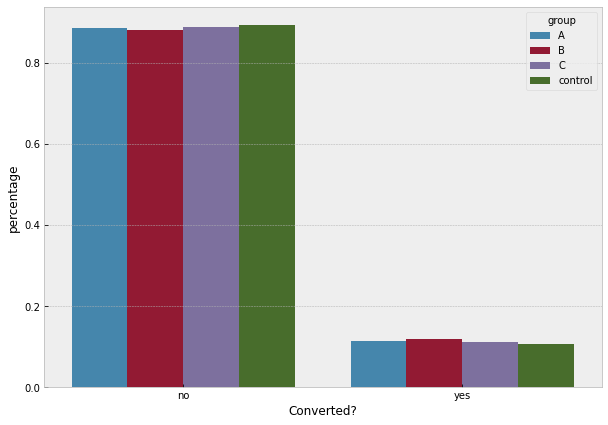

In [40]:
fig, ax=plt.subplots(figsize=(10,7))

conversion_count=(df.groupby(["group"])['converted']
                    .value_counts(normalize=True)
                    .rename("percentage")
                    .reset_index())

sns.barplot(data=conversion_count, x="converted", y="percentage", hue="group", ax=ax)

ax.set_xlabel("Converted?")
ax.set(xticklabels=["no","yes"])

Lets determine the actual numbers.

In [41]:
df

,treatment,new_images,converted,group
0,1,1,0,A
1,1,1,0,A
2,1,1,0,A
3,1,0,0,B
4,0,1,0,C
...,...,...,...,...
40479,0,0,0,control
40480,1,1,0,A
40481,1,1,0,A
40482,0,0,0,control


In [42]:
df[df.group=="A"].converted.mean()

0.11372394032210256

In [43]:
GROUP_CONV_RATE={}

print("Observed conversion rate")

for i in range(15):
    print("-", end=" ")

print()

for group in df.group.unique():
    conv_rate=df[df.group==group].converted.mean()
    GROUP_CONV_RATE[group]=conv_rate

    print(f"Group {group} : {conv_rate:.3f}")

Observed conversion rate
- - - - - - - - - - - - - - - 
Group A : 0.114
Group B : 0.120
Group C : 0.113
Group control : 0.107


Group B has an observed conversion rate of 12% which is 1.3% more than 10.7%, the observed conversion rate of the control group. A and group C on the other hand have approximately a 0.7% and 0.6% increase in its observed conversion rate as compared to the control group's

#### USING PIVOT TABLES

In [44]:
pd.pivot_table(df, values="converted",
                index=['treatment'],
                columns=['new_images'],
                aggfunc=np.mean)

new_images,0,1
treatment,,
0,0.107104,0.112538
1,0.120047,0.113724


### *2. Measuring success of redesign using Bayesian A/B testing*

I will use the Bayesian inference to explain the increase in observed converison rate of groups A,B, and C since it has better explainability as compared to the frequentist appraoch using p-values.

We first define a helper fucntion `from_posterior` which helps us to update our "prior"
since our dataset is quite large to do Bayesian inference on small compute capacity.

In [45]:
from pymc3.distributions import Interpolated

def from_posterior(param, samples):
    """https://docs.pymc.io/en/v3/pymc-examples/examples/pymc3_howto/updating_priors.html"""
    smin, smax=np.min(samples), np.max(samples)
    width=smax-smin
    x=np.linspace(smin,smax,100)
    y=stats.gaussian_kde(samples)(x)

    x=np.concatenate([[x[0]-3 * width], x, [x[-1] + 3 * width]])
    y=np.concatenate([[0],y,[0]])

    return Interpolated(param, x, y)


 Lets now extract the group `converted` observations which will be used for inference in the next section

In [46]:
def prep_group_data(group_name):
    return df[df.group==group_name].converted.to_numpy().reshape(-1,1)



group_data={
    "A":prep_group_data('A'),
    "B":  prep_group_data('B'),
    "C": prep_group_data('C'),
    "control": prep_group_data('control')
}

#### Thinking how our data is generated

There are four unknown paramters to infer here -- these are the conversion rates of the groups A,B,C, and control which are probabiliies between 0 and 1. We will label these conversion rates as $p_{A}$,$p_{B}$,$p_{C}$, and $p_{control}$ respectively.

Since we dont have any prior belief on these conversion rates, we assume as a starting point that each of these conversion rates is equally likely over all possible values between 0 and 1. That is, for example, our current initial belief is that it is eqaully likely for $p_{A}$ to be 0.13 as it is to be 0.97(random).In Bayesion lingo, this means that we assume a uniform prior over the interval [0,1] for each of thse conversion rates.

We then incorporate our observed conversion rate using a Bernoulli distribution conditioned on the prior conversion rates. This is where "training" happens if we think of Bayesioan modellinh as training a generic machine learning model.By incorporating obssevation, we are able to update our prior beliefe into a so-called posterior belief. 

In [47]:
def sample_posterior(data, batch_size=5000):
    traces=[]

    for i in range(0,len(data),batch_size):
        batch_data=data[i:i+batch_size]

        model=pm.Model()

        with model:
            #Prior

            if len(traces)==0:
                p=pm.Uniform("p",0,1)

            else:
                p=from_posterior('p',burned_trace['p'])
            
            #Likelihood
            obs=pm.Bernoulli('obs',p,observed=batch_data)
            # Inference

            trace=pm.sample(11000, step=pm.Metropolis())

            burned_trace=trace[1000:]

            traces.append(burned_trace)

    return traces

Using the Metropolis inference engine, we sample the posterior distribution of the conversion rates $p_{A}$,$p_{B}$,$p_{C}$, and $p_{control}$ which in probabilisti programming lingo is called traces

In [48]:
import warnings

warnings.filterwarnings("ignore")

In [49]:
import logging


In [50]:

logger=logging.getLogger('pymc3')
logger.setLevel(logging.ERROR)

traces_A=sample_posterior(group_data['A'])
traces_B=sample_posterior(group_data['B'])
traces_C=sample_posterior(group_data['C'])
traces_control=sample_posterior(group_data['control'])


In [51]:
def final_samples(trace):
    return trace[-1]['p']

final_trace={
    "A": final_samples(traces_A),
    "B": final_samples(traces_B),
    "C": final_samples(traces_C),
    "control": final_samples(traces_control),
}

We plot the posterior distribution of the four conversion rates we wanted to infer:

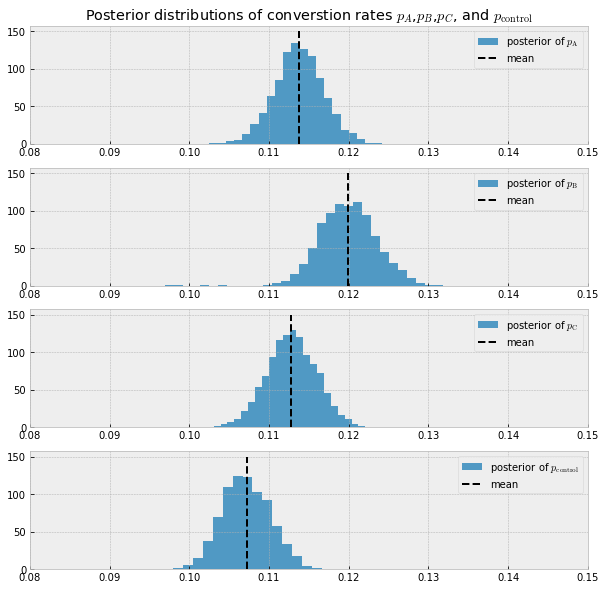

In [52]:
fig, ax=plt.subplots(4, 1, figsize=(10,10))

ax[0].set_title('Posterior distributions of converstion rates $p_A$,$p_B$,$p_C$, and $p_{\mathrm{control}}$')


for i, group in enumerate(df.group.unique()):
    ax[i].set_xlim(0.08, 0.15)

    group_final_trace=final_trace[group]
    label='posterior of $p_{\mathrm{' + f'{group}' + '}}$'

    ax[i].hist(group_final_trace,
                histtype='stepfilled',
                bins=100, alpha=0.85, density=True, 
                label=label) #       rlororsswdffwfhhhhfdtgetttttttttttttttcolor=BMH_COLORS[i])

    ax[i].vlines(group_final_trace.mean(),0 ,150, color='black', linestyle="--", label='mean')
    ax[i].legend()


plt.show()

To see it more clearly, we plot the difference $\Delta_{A}$(respectively $\Delta_{B}$, $\Delta_{C}$) between the posterior of the test group A(respectively B, C) and the posterior of the control group.

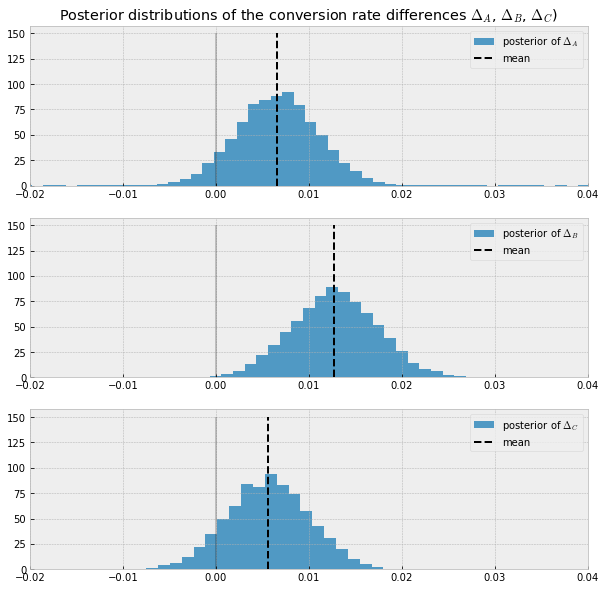

In [54]:
fig, ax=plt.subplots(3,1, figsize=(10,10))

ax[0].set_title('Posterior distributions of the conversion rate differences $\Delta_{A}$, $\Delta_{B}$, $\Delta_{C}$)')

for i, group in enumerate(['A', 'B', 'C']):
    ax[i].set_xlim(-0.02,0.04)

    group_delta_trace=final_trace[group]-final_trace['control']
    label=f'posterior of $\Delta_{group}$'

    ax[i].hist(group_delta_trace,
                histtype='stepfilled'
              ,bins=100, alpha=0.85, density=True,
              label=label,) #color=BMH_COLORS[i])


    ax[i].vlines(group_delta_trace.mean(),0,150, color='black', linestyle='--', label='mean')
    ax[i].vlines(0,0,150 , color='black', alpha=0.2)

    ax[i].legend()


plt.show()

Based on the posterior distributions of converstions rate difference $\Delta_{A}$,$\Delta_{B}$, $\Delta_{C}$, we observe that most of the distribution lies above 0. This implies that each group A, B and  C is more liekly to have a higher conversion rate that the control group. That is, the corresponding website version of groups A, B and C respectively are all major improvments over the current version. However, it should be obvious that there's a clear winner: group B seems to be most liekly to have a higher conversion rate that the control.

The actual probabilities of the group are computed below:

In [57]:
for group in ['A','B','C']:
    print("Probability that user group {0} has higher conversion rate than control: {1:.3f}".format(group,((final_trace[group]-final_trace['control'])>0).mean()))

Probability that user group A has higher conversion rate than control: 0.932
Probability that user group B has higher conversion rate than control: 0.991
Probability that user group C has higher conversion rate than control: 0.900


#### Conclusion
The probabilites agree with our observation and discussion. In fact, we have a more granular observation.

Group B with approximately 0.99 probability is the most likly to have a higher conversion rate than the control. Now group A has a probability of 0.93 which is higher than the probability of group C of 0.9 So it is more likely that user group A has a higher conversion rate than the control, as compared to group C. This establishes a hierrachy of website redesign performance as follows:

B is best performing, followed by A, and then lastly C.

### *3. Fresh new landing page, but same good ol' images is the way to go*
Recall what the group A, B and C means:

* user group A: saw the **new** version of the **landing page**, wuth **new set of images**
* user group B: saw the **new** version of the **landing page**, wuth **old set of images**
* user group C: saw the **old** version of the **landing page**, wuth **new set of images**
* user group control: saw the **new** version of the **landing page**, wuth **new set of images**

So our conclsuion from the previous section suggested that there is a hierachy of website redesign performance like so:

1. **Best performing:** use the new landing page, but keep the old set of images;
2. **Second best:** use both the new landing page and new set of images:
3. **Third best:** use the new set of images, but keep the old landing page.

And each of them have more than 90% probability of being better than just using the old landing page and old set of images! So we only have a 10% chance of being wrong if we choose any of them, which is quite a small risk already.

#### Conclusion
But if we need to choose one, just redesign the website using the **new landing page** but maintain the **old set of images**. In this case, we only have a 1% chance of being wrong, a ver tiny risk.